# Making the graph:

In [26]:
# Import statements
import os
import re
import json
import csv
import networkx as nx
from langdetect import detect, LangDetectException
from community import community_louvain
from deep_translator import GoogleTranslator
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import modularity
import matplotlib.pyplot as plt
import numpy as np  
from networkx.algorithms.community.quality import modularity
from scipy.stats import ttest_ind
import math
import string
import nltk
from collections import Counter, defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from googletrans import Translator

In [3]:
!pip install deep-translator

### Loading the json-files, comment-files and transcript-files for each node and storing it translated with the used attributes in a node-json file in the node_files folder: 

In [14]:
translator = GoogleTranslator()

# Paths to the folders
comments_base_path = "Data/node-files exist"  # Folder containing country folders with comments
transcripts_base_path = "Data/video_transcripts"  # Folder containing country folders with transcripts
json_folder = "Data/complete"
node_files_folder = "Data/node_files"  # Folder where node data will be saved

# Create the node_files folder if it doesn't exist
if not os.path.exists(node_files_folder):
    os.makedirs(node_files_folder)

# Iterate over country folders in the comments directory
country_folders = [folder for folder in os.listdir(comments_base_path) if os.path.isdir(os.path.join(comments_base_path, folder))]

print("Nr. of countries:", len(country_folders))

# Initialize count
count = 0  # Total number of videos processed

for country_folder in country_folders:
    comments_country_path = os.path.join(comments_base_path, country_folder)
    transcripts_country_path = os.path.join(transcripts_base_path, country_folder)  # Corresponding transcript folder
    country_name = country_folder

    print("Processing country:", country_name)

    # Load the corresponding JSON file for video data
    json_file_path = os.path.join(json_folder, f"{country_name}.json")
    with open(json_file_path, 'r', encoding='utf-8') as f:
        video_data = json.load(f)

    # Map video ID to its attributes
    video_attributes = {
        video['id']: {
            "title": video.get('snippet', {}).get('title', ''),
            "channelTitle": video.get('snippet', {}).get('channelTitle', ''),
            "description": video.get('snippet', {}).get('description', ''),
            "viewCount": video.get('statistics', {}).get('viewCount', '0'),
            "likeCount": video.get('statistics', {}).get('likeCount', '0'),
            "publishedAt": video.get('snippet', {}).get('publishedAt', ''),
            "tags": video.get('snippet', {}).get('tags', []),
            "categoryId": video.get('snippet', {}).get('categoryId', '')
        }
        for video in video_data
    }

    # Iterate over txt files in the comments folder
    txt_files = [file for file in os.listdir(comments_country_path) if file.endswith('.txt')]
    count += len(txt_files)

    for txt_file in txt_files:
        video_name = os.path.splitext(txt_file)[0]

        # Read comments from the txt file
        txt_file_path = os.path.join(comments_country_path, txt_file)
        with open(txt_file_path, 'r', encoding='utf-8') as f:
            comments = f.read()

        # Check for transcript file
        transcript_file_path = os.path.join(transcripts_country_path, f"{video_name}.txt")
        transcript = None
        if os.path.exists(transcript_file_path):
            with open(transcript_file_path, 'r', encoding='utf-8') as f:
                transcript = f.read()

        # Define the node file path
        node_file_path = os.path.join(node_files_folder, f"{video_name}.json")

        # If the node already exists, update only the country attribute
        if os.path.exists(node_file_path):
            with open(node_file_path, 'r', encoding='utf-8') as f:
                node_data = json.load(f)

            if 'country' not in node_data:
                node_data['country'] = []
            if country_name not in node_data['country']:
                node_data['country'].append(country_name)

            # Save the updated node
            with open(node_file_path, 'w', encoding='utf-8') as f:
                json.dump(node_data, f, ensure_ascii=False, indent=4)

            continue

        # Create a new node
        node_data = {
            "comments": comments,
            "country": [country_name],
        }

        if transcript:
            node_data["transcript"] = transcript

        # Add video attributes if they exist
        if video_name in video_attributes:
            video_info = video_attributes[video_name]
            node_data.update(video_info)

            # Translate description if necessary
            description = video_info.get("description", "")
            try:
                if description and detect(description) != "en":
                    node_data["description"] = translator.translate(description, source="auto", target="en")
            except Exception as e:
                print(f"Error translating description for '{video_name}': {e}")

            # Translate tags if necessary
            tags = video_info.get("tags", [])
            translated_tags = []
            for tag in tags:
                try:
                    if detect(tag) != "en":
                        translated_tags.append(translator.translate(tag, source="auto", target="en"))
                    else:
                        translated_tags.append(tag)
                except Exception as e:
                    print(f"Error translating tag '{tag}' for '{video_name}': {e}")
                    translated_tags.append(tag)
            node_data["tags"] = translated_tags

        # Save the new node
        with open(node_file_path, 'w', encoding='utf-8') as f:
            json.dump(node_data, f, ensure_ascii=False, indent=4)
            
        print(f"New node for '{video_name}' saved.")

print(f"Total videos processed: {count}")

FileNotFoundError: [Errno 2] No such file or directory: 'Data/node-files exist'

### Loading network from the "node_files" folder:

In [5]:
# Initialize the graph
G = nx.Graph()

# Path to the folder with saved node files
node_files_folder = "node_files"

# Load the node information from the "node_files" folder
node_files = [file for file in os.listdir(node_files_folder) if file.endswith('.json')]

# Iterate over each saved node file to load attributes and build the graph
for node_file in node_files:
    node_file_path = os.path.join(node_files_folder, node_file)
    
    with open(node_file_path, 'r', encoding='utf-8') as f:
        node_data = json.load(f)
    
    video_name = os.path.splitext(node_file)[0]
    
    # Add node to the graph with the loaded attributes
    G.add_node(video_name, **node_data)

# Define the threshold for edge weight
threshold = 0.1  # Adjust this value as needed 0.001

# Add weighted edges based on shared tags
nodes = list(G.nodes(data=True))
for i, (node1, attr1) in enumerate(nodes):
    tags1 = set(attr1.get('tags', []))
    for j in range(i + 1, len(nodes)):
        node2, attr2 = nodes[j]
        tags2 = set(attr2.get('tags', []))
        
        # Calculate the weight as [number of shared tags] / [sum of tags of the two nodes]
        shared_tags = tags1 & tags2
        weight = len(shared_tags) / (len(tags1) + len(tags2)) if (len(tags1) + len(tags2)) > 0 else 0
        
        # Add the edge only if the weight is above the threshold
        if weight > threshold:
            G.add_edge(node1, node2, weight=weight)

print("Total number of nodes:", G.number_of_nodes())

# Remove isolated nodes
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

# Print network summary
print("Total number of nodes after removing isolated ones:", G.number_of_nodes())
print("Total number of edges:", G.number_of_edges())

Total number of nodes: 1543
Total number of nodes after removing isolated ones: 647
Total number of edges: 719


### Plotting the number of links per threshold (use that to argue which threshold we took):

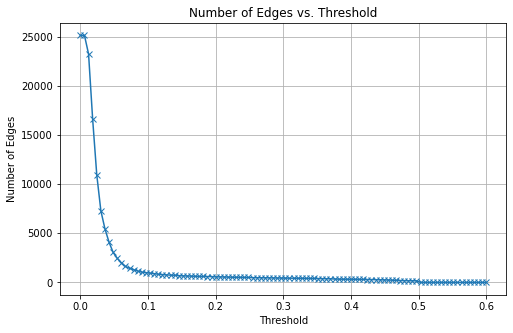

In [37]:
# Define a range of thresholds to evaluate
thresholds = np.linspace(0, 0.6, 100)  # 100 thresholds between 0 and 0.6 (afterwards are barely ay edges)
edge_counts = []

# Evaluate the number of edges for each threshold
for threshold in thresholds:
    temp_graph = nx.Graph()
    
    # Add edges to the temporary graph based on the current threshold
    for i, (node1, attr1) in enumerate(nodes):
        tags1 = set(attr1.get('tags', []))
        for j in range(i + 1, len(nodes)):
            node2, attr2 = nodes[j]
            tags2 = set(attr2.get('tags', []))
            
            shared_tags = tags1 & tags2
            weight = len(shared_tags) / (len(tags1) + len(tags2)) if (len(tags1) + len(tags2)) > 0 else 0
            
            if weight > threshold:
                temp_graph.add_edge(node1, node2, weight=weight)
    
    # Record the number of edges for this threshold
    edge_counts.append(temp_graph.number_of_edges())

# Plot the threshold vs. edge count
plt.figure(figsize=(8, 5))
plt.plot(thresholds, edge_counts, marker='x')
plt.xlabel("Threshold")
plt.ylabel("Number of Edges")
plt.title("Number of Edges vs. Threshold")
plt.grid(True)
plt.show()


### Plotting the degree distribution:

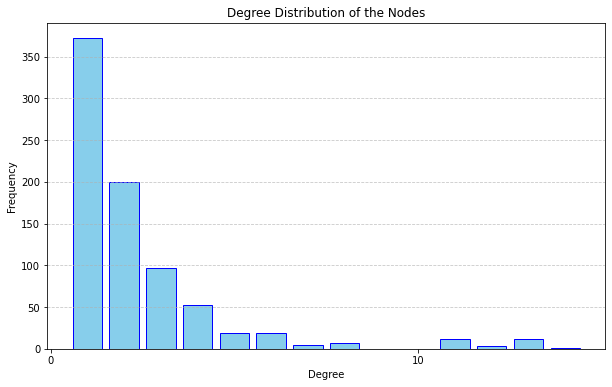

In [38]:

# Calculate degree distribution
degree_sequence = [G.degree(n) for n in G.nodes]
degree_count = {deg: degree_sequence.count(deg) for deg in set(degree_sequence)}
degrees, counts = zip(*sorted(degree_count.items()))

# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.bar(degrees, counts, width=0.8, color='skyblue', edgecolor='blue')
plt.title("Degree Distribution of the Nodes")
plt.xlabel("Degree")
plt.ylabel("Frequency")

# Set x-ticks every 10
max_degree = max(degrees)
plt.xticks(np.arange(0, max_degree + 1, 10))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### The structural communities based on the Python Louvain-algorithm will be detected:

In [7]:
# Using Louvain to find communities
louvain_partition = community_louvain.best_partition(G)

# Calculating the modularity
partition_louvain = {}
for node, community in louvain_partition.items():
    if community not in partition_louvain:
        partition_louvain[community] = []
    partition_louvain[community].append(node)

# Convert partition into a list of sets for modularity calculation
partition_list_louvain = [set(nodes) for nodes in partition_louvain.values()]
modularity_value_louvain = nx.algorithms.community.quality.modularity(G, partition_list_louvain)

# Displaying results
print(f"Number of Louvain communities detected: {len(partition_louvain)}")
print(f"Louvain modularity: {modularity_value_louvain:.5f}")

# Save community assignments to nodes
nx.set_node_attributes(G, louvain_partition, "louvain-community")


Number of Louvain communities detected: 224
Louvain modularity: 0.97638


### Communities and Modularity based on Country (only taken the first country in the list) and CategoryID:

In [64]:
# Community Assignment by `country`
country_partition = {}
for node, data in G.nodes(data=True):
    countries = data.get('country', [])
    primary_country = countries[0] if countries else 'Unknown'  # Use the first country if available
    data['country_community'] = primary_country
    country_partition[node] = primary_country  # Record the primary country for modularity calculation

# Community Assignment by `CategoryID`
category_partition = {}
for node, data in G.nodes(data=True):
    category = data.get('categoryId', [])
    data['category_community'] = category
    category_partition[node] = category  # Record the catefory for modularity calculation

# Modularity calculation for `country_community`
country_communities = {c: [] for c in set(country_partition.values())}
for node, community in country_partition.items():
    country_communities[community].append(node)
country_modularity = modularity(G, country_communities.values())
print(f"Modularity for Country communities: {country_modularity:.4f}")

# Modularity calculation for `category id`
category_communities = {c: [] for c in set(category_partition.values())}
for node, community in category_partition.items():
    category_communities[community].append(node)
category_modularity = modularity(G, category_communities.values())
print(f"Modularity for Category communities: {category_modularity:.4f}")


Modularity for Country communities: 0.5032
Modularity for Category communities: 0.7618


## Visualising Node count by Community

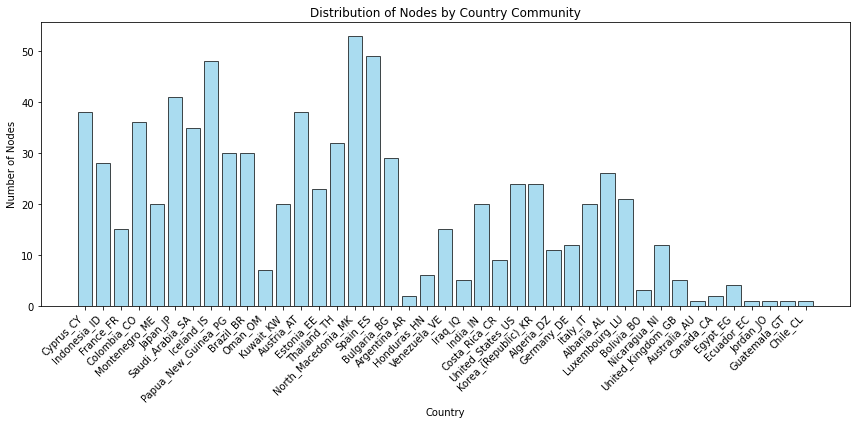

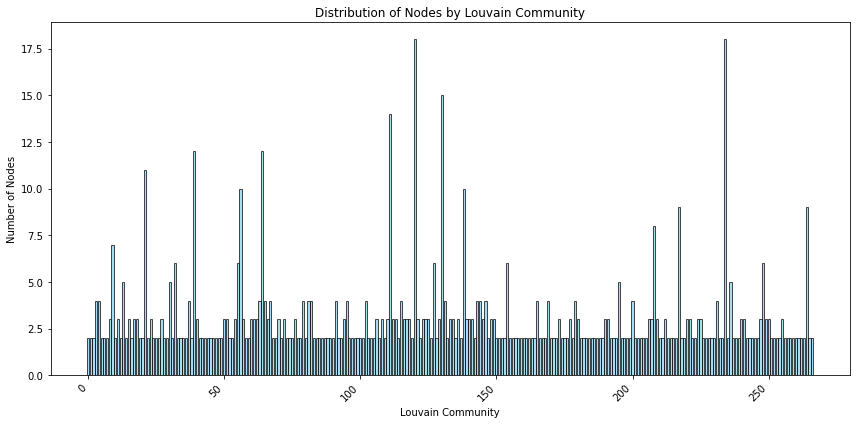

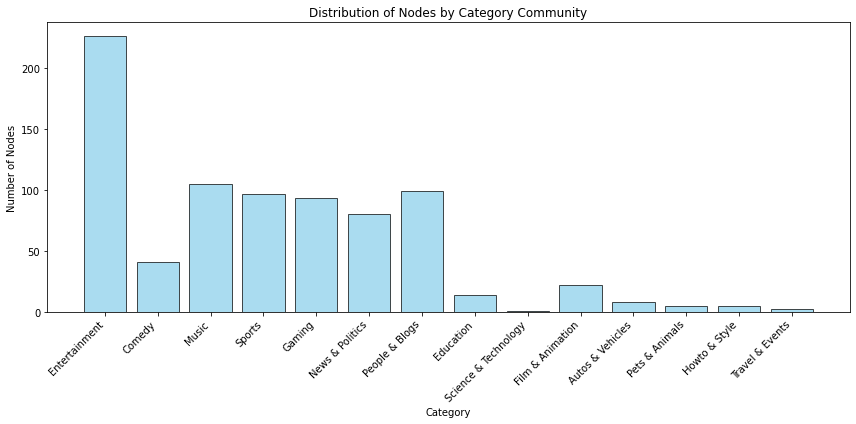

In [41]:
import matplotlib.pyplot as plt
from collections import Counter

# Define category mapping (if not already defined)
category_mapping = {
    1: "Film & Animation", 2: "Autos & Vehicles", 10: "Music", 15: "Pets & Animals", 17: "Sports", 18: "Short Movies",
    19: "Travel & Events", 20: "Gaming", 21: "Videoblogging", 22: "People & Blogs", 23: "Comedy", 24: "Entertainment",
    25: "News & Politics", 26: "Howto & Style", 27: "Education", 28: "Science & Technology", 29: "Nonprofits & Activism",
    30: "Movies", 31: "Anime/Animation", 32: "Action/Adventure", 33: "Classics", 34: "Comedy", 35: "Documentary",
    36: "Drama", 37: "Family", 38: "Foreign", 39: "Horror", 40: "Sci-Fi/Fantasy", 41: "Thriller", 42: "Shorts",
    43: "Shows", 44: "Trailers"
}

# Function to plot distribution
def plot_distribution(partition, title, xlabel, mapping=None):
    # Count the number of nodes in each community
    community_counts = Counter(partition.values())
    
    # Prepare data for plotting
    communities, counts = zip(*community_counts.items())
    
    # Map communities to names if a mapping is provided
    if mapping:
        communities = [mapping[int(comm)] if int(comm) in mapping else f"Community {comm}" for comm in communities]
    
    # Plot the distribution
    plt.figure(figsize=(12, 6))
    plt.bar(communities, counts, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Number of Nodes")
    plt.tight_layout()
    plt.show()

# Plot distributions for each community type
plot_distribution(
    country_partition,
    title="Distribution of Nodes by Country Community",
    xlabel="Country"
)

# louvain_partition should be a dictionary mapping nodes to their community
plot_distribution(
    louvain_partition,
    title="Distribution of Nodes by Louvain Community",
    xlabel="Louvain Community"
)

plot_distribution(
    category_partition,
    title="Distribution of Nodes by Category Community",
    xlabel="Category",
    mapping=category_mapping  # Pass the category mapping for labeling
)


## Visualizing Network based on different communities --> MAYBE ADD MAX COMMUNITIES FOR THE LOUVAIN PARTITION

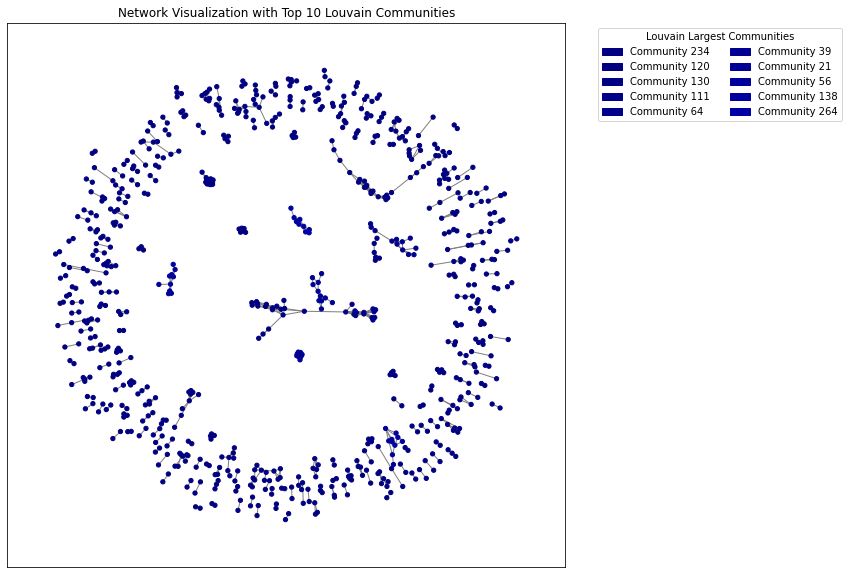

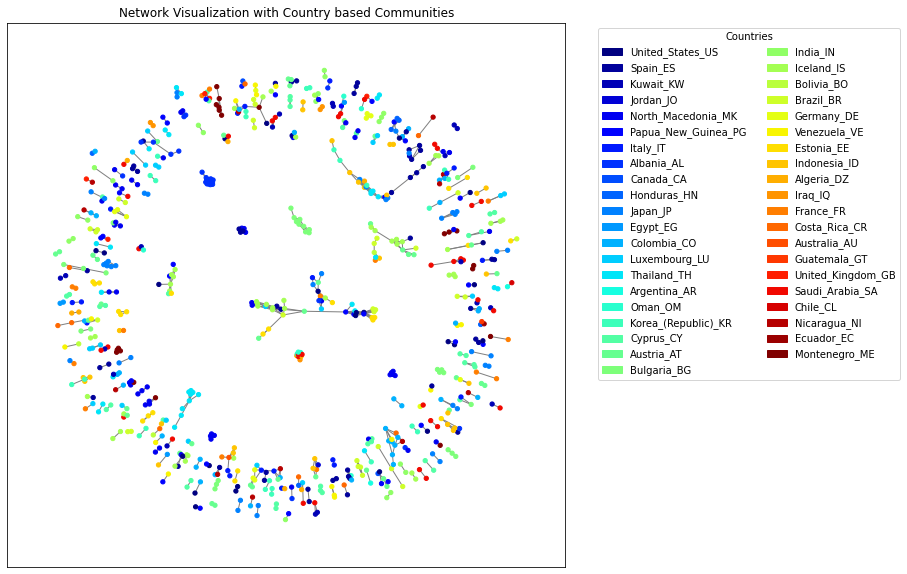

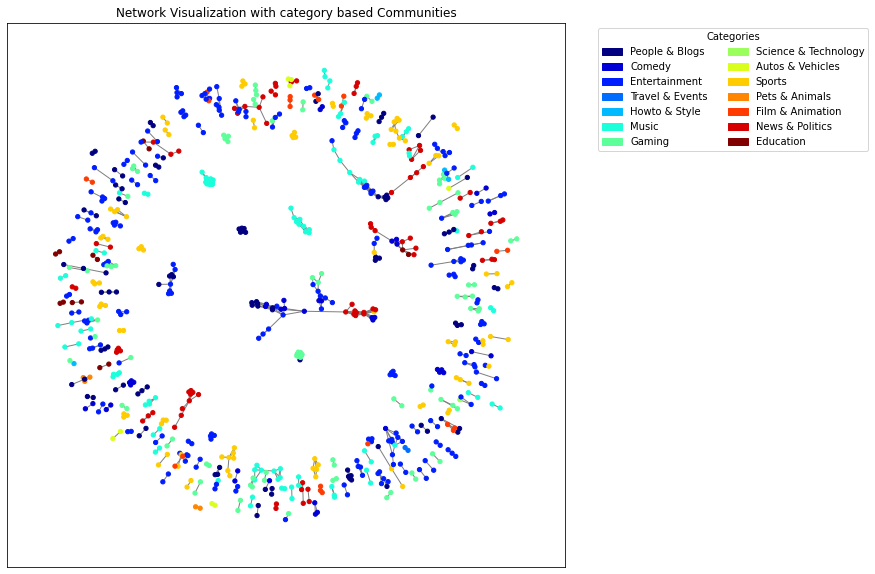

In [42]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize

def visualize_network_with_communities(G, partition_type, plot_title, legend_title):

    # Visualizing the network using Force Atlas or Spring Layout
    pos = nx.spring_layout(G, seed=42)


    unique_communities = set(partition_type.values())
    if partition_type == louvain_partition:
        community_sizes = Counter(partition_type.values())
        largest_communities = [community for community, size in community_sizes.most_common(10)]
        community_color_map = {community: idx for idx, community in enumerate(largest_communities)}
        community_colors = [community_color_map.get(partition_type[video], -1) for video in G.nodes()]
        
    else:
        
        community_color_map = {community: idx for idx, community in enumerate(unique_communities)}
        community_colors = [community_color_map[partition_type[video]] for video in G.nodes()]
    # Coloring the nodes based on the structural community
    # unique_communities = set(partition_type.values())
    # community_color_map = {community: idx for idx, community in enumerate(unique_communities)}
    # community_colors = [community_color_map[partition_type[video]] for video in G.nodes()]
    cmap = plt.cm.jet
    #cmap = plt.get_cmap('Set3')
    # Normalizing community colors
    norm = Normalize(vmin=0, vmax=len(unique_communities) - 1)

    # Drawing the network
    plt.figure(figsize=(10, 10))
    nx.draw_networkx(
        G, pos,
        node_color=community_colors,
        cmap=cmap,
        with_labels=False,
        node_size=18,
        edge_color='gray',
        vmin=0, vmax=len(unique_communities) - 1
    )

    # Creating the legend
    if partition_type == category_partition:
        category_mapping = {
    1: "Film & Animation",2: "Autos & Vehicles",10: "Music",15: "Pets & Animals",17: "Sports",18: "Short Movies",19: "Travel & Events",20: "Gaming",21: "Videoblogging",22: "People & Blogs",
    23: "Comedy",24: "Entertainment",25: "News & Politics",26: "Howto & Style",27: "Education",28: "Science & Technology",29: "Nonprofits & Activism",30: "Movies",31: "Anime/Animation",
    32: "Action/Adventure",33: "Classics",34: "Comedy",35: "Documentary",36: "Drama",37: "Family",38: "Foreign", 39: "Horror",40: "Sci-Fi/Fantasy",41: "Thriller",42: "Shorts",43: "Shows",44: "Trailers"
}
        
        legend_handles = []
        for community in unique_communities:
            label = category_mapping[int(community)]
            color = cmap(norm(community_color_map[community]))
            legend_handles.append(mpatches.Patch(color=color, label=label))
                
    elif partition_type == country_partition:
        legend_handles = [
            mpatches.Patch(color=cmap(norm(community_color_map[community])), label=f'{community}')
            for community in unique_communities
        ]      
    else:
        legend_handles = [
            mpatches.Patch(color=cmap(norm(community_color_map[community])), label=f'Community {community}')
            for community in largest_communities
        ]
    plt.legend(handles=legend_handles, title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 2)
    plt.title(plot_title)
    plt.show()

# Example usage for four different inputs
inputs = [
    {"partition_type": louvain_partition, "plot_title": "Network Visualization with Top 10 Louvain Communities", "legend_title": "Louvain Largest Communities"},
    {"partition_type": country_partition, "plot_title": "Network Visualization with Country based Communities", "legend_title": "Countries"},
    {"partition_type": category_partition, "plot_title": "Network Visualization with category based Communities", "legend_title": "Categories"}
]

# Loop through the inputs and visualize
for input_data in inputs:
    visualize_network_with_communities(
        G=G,
        partition_type=input_data["partition_type"],
        plot_title=input_data["plot_title"],
        legend_title=input_data["legend_title"]
    )


## Extracting Network Backbone (Disparity Filter) --> REMOVE????
backbone which is a simplified version of the network retaining its main structure and properties.

In [43]:
# Function to write the graph to a text file
def write_graph_to_file(graph, filename):
    # Open file to write
    with open(filename, 'w') as f:
        # Write the header
        f.write("src\ttrg\tweight\n")

        # Iterate over edges and write the source, target, and weight
        for u, v, data in graph.edges(data=True):
            f.write(f"{u}\t{v}\t{data['weight']}\n")

            # If undirected, ensure symmetry (write both directions)
            if not graph.is_directed():
                f.write(f"{v}\t{u}\t{data['weight']}\n")

# Call the function to write the graph to a text file
write_graph_to_file(G, "youtubeNet.txt")


In [44]:
import backboning
import os
table, nnodes, nnedges = backboning.read("youtubeNet.txt", "weight")
nc_table = backboning.noise_corrected(table)
nc_backbone = backboning.thresholding(nc_table, 0.6)
backboning.write(nc_backbone, "youtubeNet", "nc", "Data")

Calculating NC score...


In [45]:
import pandas as pd
# Load the CSV file (replace 'your_file.csv' with the path to your actual file)
filename = 'Data/youtubeNet_nc.csv'  # update with the actual path to your CSV file
df = pd.read_csv(filename, sep='\t')  # ensure the separator matches your file format, e.g., comma, semicolon

# Create the graph from the CSV file
G_backbone = nx.Graph()  # Use nx.DiGraph() if you need a directed graph

# Add edges with 'score' as weight from the CSV
for index, row in df.iterrows():
    G_backbone.add_edge(row['src'], row['trg'], weight=row['score'])

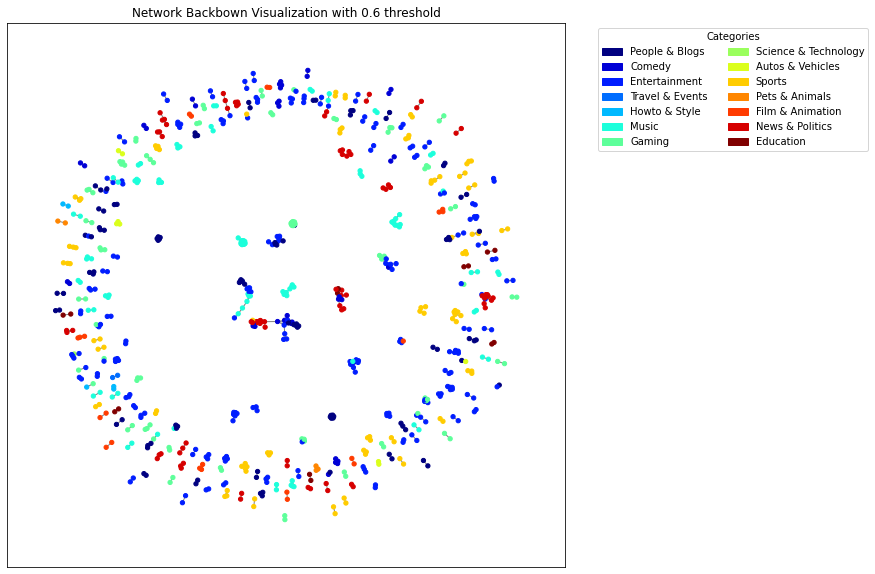

In [46]:
inputs = [
    {"partition_type": category_partition, "plot_title": "Network Backbown Visualization with 0.6 threshold", "legend_title": "Categories"},
]

# Loop through the inputs and visualize
for input_data in inputs:
    visualize_network_with_communities(
        G=G_backbone,
        partition_type=input_data["partition_type"],
        plot_title=input_data["plot_title"],
        legend_title=input_data["legend_title"]
    )


## Measuring closeness centrality, eigenvector centrality, betweeness centrality and degree centrality

- Closeness Centrality measures how close a node is to all other nodes in the graph.
- Eigenvector Centrality measures the influence of a node based on the importance of its neighbors.
- Betweenness Centrality measures how often a node acts as a bridge along the shortest path between two other nodes.
- Degree Centrality the number of edges connected to a node.


In [47]:
from deep_translator import GoogleTranslator  # Ensure the translator is imported from deep_translator
translator = GoogleTranslator()
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Get the most central nodes based on degree centrality
most_central_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)

# Print titles of the most central nodes
print("Most central 5 nodes by degree centrality:")
for node in most_central_nodes[:5]:
    title = G.nodes[node].get('title', 'No Title')  # Get the 'title' attribute or default to 'No Title'
    country = G.nodes[node].get('country', 'No country')
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Title: {translated_title}, Country: {country}")

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Get the most central nodes based on betweenness centrality
most_between_central_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)

# Print titles of the most between-central nodes
print("\nMost central 5 nodes by betweenness centrality:")
for node in most_between_central_nodes[:5]:
    title = G.nodes[node].get('title', 'No Title')  # Get the 'title' attribute or default to 'No Title'
    country = G.nodes[node].get('country', 'No country')
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Title: {translated_title}, Country: {country}")


eigenvector_centrality = nx.eigenvector_centrality(G)
most_eigenvector_central_nodes = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)
print("\nMost central 5 nodes by eigenvector centrality:")
for node in most_eigenvector_central_nodes[:5]:
    title = G.nodes[node].get('title', 'No Title')  # Get the 'title' attribute or default to 'No Title'
    country = G.nodes[node].get('country', 'No country')
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Title: {translated_title}, Country: {country}")


closeness_centrality = nx.closeness_centrality(G)
most_closeness_central_nodes = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)
print("\nMost central 5 nodes by closeness centrality:")
for node in most_closeness_central_nodes[:5]:
    title = G.nodes[node].get('title', 'No Title')  # Get the 'title' attribute or default to 'No Title'
    country = G.nodes[node].get('country', 'No country')
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Title: {translated_title}, Country: {country}")



Most central 5 nodes by degree centrality:
Title: RONELA HAJATI – LABYRINTH (Magic Song 2024) #musicistheanswer, Country: ['Albania_AL']
Title: MatoLale - TopBoy (starring by Reis Cico), Country: ['Albania_AL']
Title: Romeo - IF OF, Country: ['Albania_AL']
Title: Elgit Doda x Xhensila x Emra Brah - Thuju, Country: ['North_Macedonia_MK', 'Albania_AL', 'Italy_IT']
Title: Olsi Bylyku ​​ft Orgito Dapa - PSE, Country: ['Albania_AL']

Most central 5 nodes by betweenness centrality:
Title: Donald Trump elected next U.S. president, Country: ['Papua_New_Guinea_PG', 'United_Kingdom_GB', 'Canada_CA']
Title: Election Touchscreen Map Takes Deeper Look Inside Key Swing Voter | Onion News Network, Country: ['Austria_AT', 'Germany_DE', 'Papua_New_Guinea_PG', 'United_Kingdom_GB', 'Australia_AU', 'Canada_CA']
Title: Don't answer unknown numbers. 🎃👻 #shorts, Country: ['Spain_ES']
Title: WORSE THAN DEATH, Country: ['Brazil_BR']
Title: LIVE: Kamala Harris concession speech after election loss (FULL), Count

## calculating assortivity based on degreed and category id

Assortativity is a measure of the tendency of nodes in a graph to connect to other nodes that share similar properties, such as degree, attributes, or other nodal characteristics.

In [48]:
from scipy.stats import pearsonr
degrees = dict(G.degree())

# assortivity based on node degrees
degree_pairs = [(degrees[u], degrees[v]) for u, v in G.edges()]
degree_a, degree_b = zip(*degree_pairs)
assortativity_coefficient, _ = pearsonr(degree_a, degree_b)
print("Assortativity Coefficient based on node degrees:", assortativity_coefficient)

# Calculate assortativity based on the 'categoryID' attribute
category_assortativity = nx.attribute_assortativity_coefficient(G, 'categoryId')
print(f"Assortativity coefficient based on 'categoryID': {category_assortativity}")


Assortativity Coefficient based on node degrees: 0.9138671473378
Assortativity coefficient based on 'categoryID': 0.8268854133585649


# TF-IDF Scores

### For Comments across Louvain Communities

In [9]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to process text
def process_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha()]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Path to the folder containing JSON files
folder_path = 'node_files'

# Load Louvain community assignments
louvain_partition = community_louvain.best_partition(G)
partition_louvain = defaultdict(list)
for node, community in louvain_partition.items():
    partition_louvain[community].append(node)

# Aggregate comments by Louvain communities
community_comments = defaultdict(list)

print("Reading JSON files and aggregating comments by Louvain communities...")
for community, nodes in partition_louvain.items():
    for node in nodes:
        file_path = os.path.join(folder_path, f"{node}.json")
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                comments = data.get('comments', '')
                if comments:
                    community_comments[community].extend(process_text(comments))

print("Calculating term frequencies...")
# Calculate Term Frequencies (TF) for each community
community_term_frequencies = {}
for community, tokens in community_comments.items():
    community_term_frequencies[community] = Counter(tokens)

# Calculate Document Frequencies (DF) across communities
document_frequency = defaultdict(int)
for term_freqs in community_term_frequencies.values():
    for word in term_freqs:
        document_frequency[word] += 1

print("Calculating TF-IDF scores...")
# Calculate Inverse Document Frequency (IDF)
N = len(community_term_frequencies)
idf_values = {word: math.log(N / df) for word, df in document_frequency.items()}

# Calculate TF-IDF for each community
community_tfidf_scores = {}
for community, term_freqs in community_term_frequencies.items():
    community_tfidf_scores[community] = {
        word: tf * idf_values[word] for word, tf in term_freqs.items()
    }

print("Finding top words by TF-IDF for each community...")
# Find the top 10 words for each community based on TF-IDF
top_words_by_community_tfidf = {}
for community, scores in community_tfidf_scores.items():
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_words_by_community_tfidf[community] = top_words

# Print the top 10 words for each community
for community, top_words in top_words_by_community_tfidf.items():
    print(f"\nTop 10 words for Louvain Community {community} based on TF-IDF:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")

print("Generating word clouds...")
# Generate and save word clouds for each community
output_folder = 'tfidf_wordclouds_Louvain'
os.makedirs(output_folder, exist_ok=True)

for community, scores in community_tfidf_scores.items():
    if scores:
        word_tfidf = dict(scores)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_tfidf)

        # Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to process text
def process_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha()]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Path to the folder containing JSON files
folder_path = 'node_files'

# Load Louvain community assignments
louvain_partition = community_louvain.best_partition(G)
partition_louvain = defaultdict(list)
for node, community in louvain_partition.items():
    partition_louvain[community].append(node)

# Aggregate comments by Louvain communities
community_comments = defaultdict(list)

print("Reading JSON files and aggregating comments by Louvain communities...")
for community, nodes in partition_louvain.items():
    for node in nodes:
        file_path = os.path.join(folder_path, f"{node}.json")
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                comments = data.get('comments', '')
                if comments:
                    community_comments[community].extend(process_text(comments))

print("Calculating term frequencies...")
# Calculate Term Frequencies (TF) for each community
community_term_frequencies = {}
for community, tokens in community_comments.items():
    community_term_frequencies[community] = Counter(tokens)

# Calculate Document Frequencies (DF) across communities
document_frequency = defaultdict(int)
for term_freqs in community_term_frequencies.values():
    for word in term_freqs:
        document_frequency[word] += 1

print("Calculating TF-IDF scores...")
# Calculate Inverse Document Frequency (IDF)
N = len(community_term_frequencies)
idf_values = {word: math.log(N / df) for word, df in document_frequency.items()}

# Calculate TF-IDF for each community
community_tfidf_scores = {}
for community, term_freqs in community_term_frequencies.items():
    community_tfidf_scores[community] = {
        word: tf * idf_values[word] for word, tf in term_freqs.items()
    }

print("Finding top words by TF-IDF for each community...")
# Find the top 10 words for each community based on TF-IDF
top_words_by_community_tfidf = {}
for community, scores in community_tfidf_scores.items():
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_words_by_community_tfidf[community] = top_words

# Print the top 10 words for each community
for community, top_words in top_words_by_community_tfidf.items():
    print(f"\nTop 10 words for Louvain Community {community} based on TF-IDF:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")

Reading JSON files and aggregating comments by Louvain communities...
Calculating term frequencies...
Calculating TF-IDF scores...
Finding top words by TF-IDF for each community...

Top 10 words for Louvain Community 0 based on TF-IDF:
trump: 410.0480
jon: 106.4618
election: 104.7030
harris: 90.7289
cbs: 81.9476
president: 75.8017
stewart: 72.4563
germany: 71.0671
democrat: 66.5421
mirko: 56.6220

Top 10 words for Louvain Community 1 based on TF-IDF:
botafogo: 163.8953
cruzeiro: 77.6346
cruise: 58.9175
diniz: 56.6220
peñarol: 54.1165
penarol: 54.1165
almada: 48.7048
libertadores: 45.0546
cassio: 43.1303
corinthian: 28.1775

Top 10 words for Louvain Community 2 based on TF-IDF:
joyca: 84.9330
trunk: 38.0221
anvil: 37.8815
object: 33.2711
padlock: 32.4699
incredible: 29.9047
imprint: 27.0582
referencing: 25.8782
impact: 24.5695
jordan: 23.3254

Top 10 words for Louvain Community 3 based on TF-IDF:
spike: 101.3568
grax: 48.7048
mortis: 33.0295
emz: 21.6466
colt: 21.5652
skin: 19.4591
bloc

In [ ]:
print("Generating word clouds...")
# Generate and display word clouds for each community
for community, scores in community_tfidf_scores.items():
    if scores:
        word_tfidf = dict(scores)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_tfidf)

        # Plot and display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"TF-IDF Word Cloud for Louvain Community {community}", fontsize=20)
        plt.show()
    else:
        print(f"No TF-IDF scores for community {community}. Skipping word cloud.")

### For comments across Countries

In [11]:
# Aggregate comments by country
country_comments = defaultdict(list)

for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            countries = data.get('country', [])  # 'country' might be a list
            comments = data.get('comments', '')

            # Check if 'countries' is a list
            if isinstance(countries, list) and comments:
                for country in countries:  # Iterate through each country
                    country_comments[country].extend(process_text(comments))
            elif isinstance(countries, str) and comments:  # Handle single string case
                country_comments[countries].extend(process_text(comments))

print("Calculating term frequencies...")
# Calculate Term Frequencies (TF) for each country
country_term_frequencies = {}
for country, tokens in country_comments.items():
    country_term_frequencies[country] = Counter(tokens)

# Calculate Document Frequencies (DF) across countries
document_frequency = defaultdict(int)
for term_freqs in country_term_frequencies.values():
    for word in term_freqs:
        document_frequency[word] += 1

print("Calculating TF-IDF scores...")
# Calculate Inverse Document Frequency (IDF)
N = len(country_term_frequencies)
idf_values = {word: math.log(N / df) for word, df in document_frequency.items()}

# Calculate TF-IDF for each country
country_tfidf_scores = {}
for country, term_freqs in country_term_frequencies.items():
    country_tfidf_scores[country] = {
        word: tf * idf_values[word] for word, tf in term_freqs.items()
    }

print("Finding top words by TF-IDF for each country...")
# Find the top 10 words for each country based on TF-IDF
top_words_by_country_tfidf = {}
for country, scores in country_tfidf_scores.items():
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_words_by_country_tfidf[country] = top_words

# Print the top 10 words for each country
for country, top_words in top_words_by_country_tfidf.items():
    print(f"\nTop 10 words for Country: {country} based on TF-IDF:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")

Calculating term frequencies...
Calculating TF-IDF scores...
Finding top words by TF-IDF for each country...

Top 10 words for Country: Iraq_IQ based on TF-IDF:
gigi: 311.3440
rania: 288.4459
veil: 103.9169
muhammad: 91.1069
sherine: 77.2530
israa: 76.2908
bandar: 70.8153
willing: 70.4356
haitham: 67.7703
bisan: 63.7195

Top 10 words for Country: Algeria_DZ based on TF-IDF:
rania: 205.5393
gigi: 201.5464
algerian: 96.9112
veil: 85.2352
willing: 83.4793
mercy: 79.8766
sherine: 77.2530
naguib: 76.1332
bandar: 67.5964
muhammad: 62.3054

Top 10 words for Country: Morocco_MA based on TF-IDF:
rania: 205.5393
gigi: 201.5464
algerian: 84.0676
muhammad: 83.4657
sherine: 77.2530
israa: 76.2908
bandar: 67.5964
sanaa: 62.2703
almighty: 61.9880
willing: 58.5100

Top 10 words for Country: Italy_IT based on TF-IDF:
danse: 106.5865
elodie: 87.5532
juric: 79.9399
yugi: 75.8254
milan: 73.4733
othello: 72.3266
enzo: 65.3499
gelsi: 64.7133
maui: 62.2703
barlow: 60.9066

Top 10 words for Country: Iceland_I

In [ ]:
print("Generating word clouds...")
# Generate and save word clouds for each country
output_folder = 'tfidf_wordclouds_by_country'
os.makedirs(output_folder, exist_ok=True)

for country, scores in country_tfidf_scores.items():
    if scores:
        word_tfidf = dict(scores)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_tfidf)

        # Plot and save the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"TF-IDF Word Cloud for Country: {country}", fontsize=20)
        plt.show()
    else:
        print(f"No TF-IDF scores for country {country}. Skipping word cloud.")

### For comments across Category IDs

In [13]:

# Define category mapping (if not already defined)
category_mapping = {
    1: "Film & Animation", 2: "Autos & Vehicles", 10: "Music", 15: "Pets & Animals", 17: "Sports", 18: "Short Movies",
    19: "Travel & Events", 20: "Gaming", 21: "Videoblogging", 22: "People & Blogs", 23: "Comedy", 24: "Entertainment",
    25: "News & Politics", 26: "Howto & Style", 27: "Education", 28: "Science & Technology", 29: "Nonprofits & Activism",
    30: "Movies", 31: "Anime/Animation", 32: "Action/Adventure", 33: "Classics", 34: "Comedy", 35: "Documentary",
    36: "Drama", 37: "Family", 38: "Foreign", 39: "Horror", 40: "Sci-Fi/Fantasy", 41: "Thriller", 42: "Shorts",
    43: "Shows", 44: "Trailers"
}

# Aggregate comments by category ID
category_comments = defaultdict(list)

print("Reading JSON files and aggregating comments by category ID...")
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            category_id = data.get('categoryId')  # Use 'categoryId' instead of 'country'
            comments = data.get('comments', '')
            if category_id and comments:
                category_comments[category_id].extend(process_text(comments))

print("Calculating term frequencies...")
# Calculate Term Frequencies (TF) for each category ID
category_term_frequencies = {}
for category, tokens in category_comments.items():
    category_term_frequencies[category] = Counter(tokens)

# Calculate Document Frequencies (DF) across categories
document_frequency = defaultdict(int)
for term_freqs in category_term_frequencies.values():
    for word in term_freqs:
        document_frequency[word] += 1

print("Calculating TF-IDF scores...")
# Calculate Inverse Document Frequency (IDF)
N = len(category_term_frequencies)
idf_values = {word: math.log(N / df) for word, df in document_frequency.items()}

# Calculate TF-IDF for each category
category_tfidf_scores = {}
for category, term_freqs in category_term_frequencies.items():
    category_tfidf_scores[category] = {
        word: tf * idf_values[word] for word, tf in term_freqs.items()
    }

print("Finding top words by TF-IDF for each category...")
# Find the top 10 words for each category based on TF-IDF
top_words_by_category_tfidf = {}
for category, scores in category_tfidf_scores.items():
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    top_words_by_category_tfidf[category] = top_words

# Print the top 10 words for each category
for category, top_words in top_words_by_category_tfidf.items():
    category_name = category_mapping.get(int(category), f"Unknown Category ({category})")
    print(f"\nTop 10 words for Category: {category_name} (ID: {category}) based on TF-IDF:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")

Reading JSON files and aggregating comments by category ID...
Calculating term frequencies...
Calculating TF-IDF scores...
Finding top words by TF-IDF for each category...

Top 10 words for Category: Comedy (ID: 23) based on TF-IDF:
dex: 197.4605
missa: 73.1174
mridul: 67.7013
kimmel: 60.4471
bujing: 59.5771
trump: 58.9294
coscu: 56.8691
ramzi: 56.4173
diwali: 54.9306
aaaaaaaaaaaaaaaa: 54.1610

Top 10 words for Category: Entertainment (ID: 24) based on TF-IDF:
ruhi: 500.9893
abhira: 333.0902
salish: 249.8480
chilsungsa: 211.2279
nidal: 203.1038
leyla: 189.5635
jx: 186.8555
fede: 186.0070
enaldinho: 163.2071
jordanmatter: 159.7750

Top 10 words for Category: Sports (ID: 17) based on TF-IDF:
player: 220.0195
goalkeeper: 202.1447
liverpool: 195.5530
coach: 186.4514
league: 173.6807
team: 171.7210
marcelo: 164.1627
corinthian: 163.0998
arsenal: 163.0998
commentator: 156.6857

Top 10 words for Category: People & Blogs (ID: 22) based on TF-IDF:
بولىدۇ: 625.5596
alchemy: 178.7313
ろ: 178.7313


In [ ]:
print("Generating word clouds...")
# Generate and save word clouds for each category
output_folder = 'tfidf_wordclouds_categoryID'
os.makedirs(output_folder, exist_ok=True)

for category, scores in category_tfidf_scores.items():
    if scores:
        word_tfidf = dict(scores)
        category_name = category_mapping.get(int(category), f"Unknown Category ({category})")
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_tfidf)

        # Plot and save the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"TF-IDF Word Cloud for {category_name} (ID: {category})", fontsize=20)
        plt.show()
    else:
        print(f"No TF-IDF scores for category ID {category}. Skipping word cloud.")

# Sentiment Analysis

In [15]:
# Function to load the LabMT word list from a CSV file and create a dictionary
def load_labmt_word_list(csv_file_path):
    labmt_words = {}

    # Open and read the CSV file
    with open(csv_file_path, mode='r', encoding='utf-8') as csv_file:
        csv_reader = csv.DictReader(csv_file)  # Use DictReader for column names
        for row in csv_reader:
            word = row['word'].lower()  # Get the word and convert to lowercase
            happiness_score = float(row['happiness_average'])  # Get the happiness score as a float
            labmt_words[word] = happiness_score  # Add word and score to the dictionary
    
    return labmt_words

csv_file_path = 'labMIT.csv'  # Replace with the correct file path
labmt_words_dict = load_labmt_word_list(csv_file_path)

print({k: labmt_words_dict[k] for k in list(labmt_words_dict)[:10]})

{'laughter': 8.5, 'happiness': 8.44, 'love': 8.42, 'happy': 8.3, 'laughed': 8.26, 'laugh': 8.22, 'laughing': 8.2, 'excellent': 8.18, 'laughs': 8.18, 'joy': 8.16}


### For overall video Comments and Transcripts

In [22]:
# Function to calculate sentiment score
def calculate_sentiment(tokens, labmt_words):
    sentiment_score = 0
    count = 0
    for token in tokens:
        if token in labmt_words:
            sentiment_score += labmt_words[token]
            count += 1
    return sentiment_score / count if count > 0 else 0

# Function to tokenize text
def process_text(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

# Folder containing JSON files for each node
folder_path = 'node_files'

# Iterate over each node in the network
for node in G.nodes():
    file_path = os.path.join(folder_path, f"{node}.json")
    
    if os.path.exists(file_path):
        # Load the JSON file
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        # Extract comments and transcript
        comments = data.get('comments', '')
        transcript = data.get('transcript', '')
        
        # Tokenize comments and transcript
        comment_tokens = process_text(comments)
        transcript_tokens = process_text(transcript)
        
        # Calculate sentiment scores
        comment_sentiment = calculate_sentiment(comment_tokens, labmt_words_dict)
        transcript_sentiment = calculate_sentiment(transcript_tokens, labmt_words_dict)
        
        # Compare sentiment scores
        sentiment_comparison = {
            'comments_sentiment': comment_sentiment,
            'transcript_sentiment': transcript_sentiment,
            'difference': abs(comment_sentiment - transcript_sentiment)
        }
        
        # Add sentiment scores as nodal properties
        G.nodes[node]['sentiment_comparison'] = sentiment_comparison
    else:
        print(f"File not found for {node}")

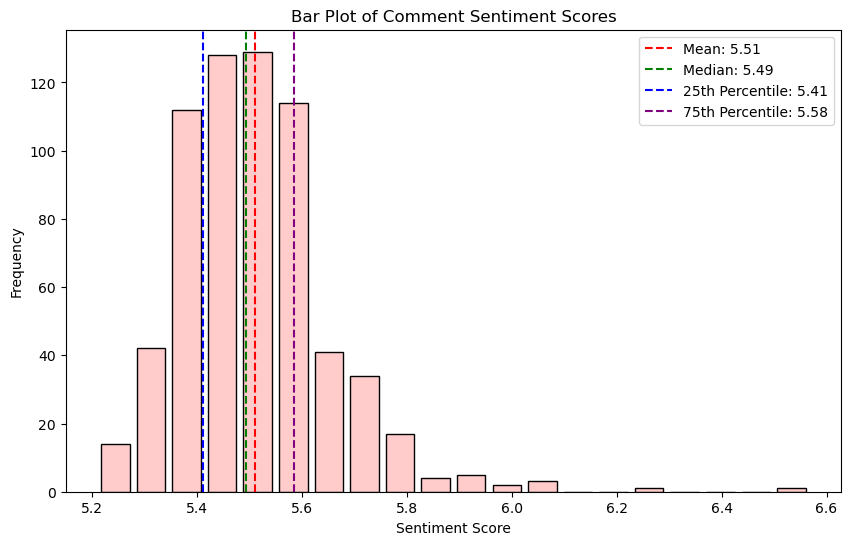

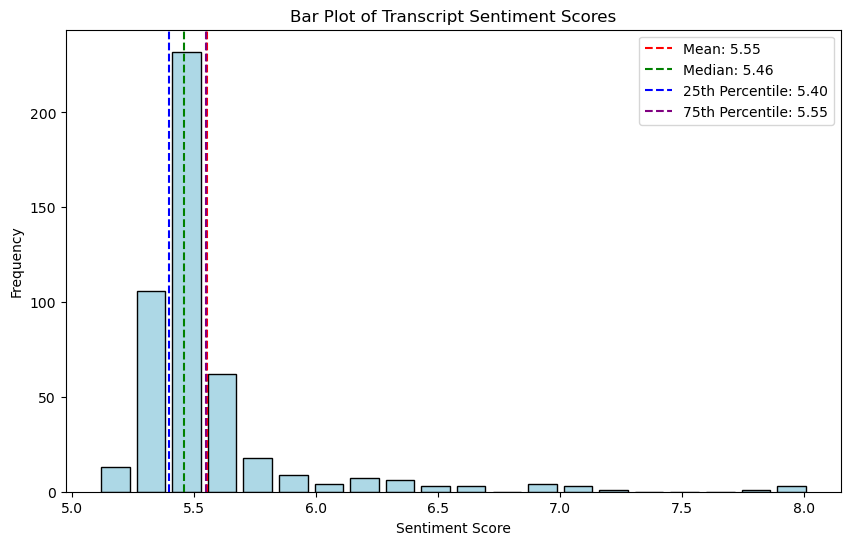


Top 10 Saddest Comments:
Title: Looking for survivors in the parking lot of the Bonaire Shopping Center in Valencia, Sentiment: 5.21, Country: ['Spain_ES']
Title: Thus Sánchez fled leaving the king and Mazón alone receiving the insults of the victims of the Dana, Sentiment: 5.21, Country: ['Spain_ES']
Title: Police for heels double killers from white field!, Sentiment: 5.22, Country: ['Montenegro_ME']
Title: Unión Comercio 0-12 Sporting Cristal: Extended summary of the Historical Party for the League1 2024, Sentiment: 5.24, Country: ['Chile_CL', 'Peru_PE']
Title: Children of the murder girl (5) and (9) for courier discovered the details as he found out about the death of his grandchildren, Sentiment: 5.24, Country: ['Montenegro_ME']
Title: American Elections: America Decides - 06/11/2024, Sentiment: 5.26, Country: ['Brazil_BR']
Title: Dana Spain |Sánchez condemns the acts of violence for which he leaves the visit to Paiporta, Sentiment: 5.26, Country: ['Spain_ES']
Title: Aggressions t

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Extract all sentiment values separately for comments and transcripts, ignoring None and 0 values
comment_sentiments = [
    data['sentiment_comparison']['comments_sentiment']
    for node, data in G.nodes(data=True)
    if data.get('sentiment_comparison', {}).get('comments_sentiment') not in (None, 0)
]

transcript_sentiments = [
    data['sentiment_comparison']['transcript_sentiment']
    for node, data in G.nodes(data=True)
    if data.get('sentiment_comparison', {}).get('transcript_sentiment') not in (None, 0)
]

# Helper function to calculate statistics and plot
def plot_sentiment_distribution(sentiments, title, color, xlabel='Sentiment Score', ylabel='Frequency'):
    # Step 2: Calculate statistical measures
    mean_sentiment = np.mean(sentiments)
    median_sentiment = np.median(sentiments)
    variance_sentiment = np.var(sentiments)
    percentile_25 = np.percentile(sentiments, 25)
    percentile_75 = np.percentile(sentiments, 75)
    
    # Step 3: Create bins for the sentiment values
    num_bins = 20
    bin_edges = np.linspace(min(sentiments), max(sentiments), num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate frequency in each bin
    frequencies, _ = np.histogram(sentiments, bins=bin_edges)
    
    # Step 4: Plot a bar plot for sentiment frequencies
    plt.figure(figsize=(10, 6))
    bar_width = (bin_edges[1] - bin_edges[0]) * 0.8  # Set bar width to 80% to create spacing
    plt.bar(bin_centers, frequencies, width=bar_width, color=color, edgecolor='black')
    
    # Add mean, median, 25th and 75th percentiles, etc.
    plt.axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_sentiment:.2f}')
    plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_sentiment:.2f}')
    plt.axvline(percentile_25, color='blue', linestyle='dashed', linewidth=1.5, label=f'25th Percentile: {percentile_25:.2f}')
    plt.axvline(percentile_75, color='purple', linestyle='dashed', linewidth=1.5, label=f'75th Percentile: {percentile_75:.2f}')
    
    # Title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Plot for comments
plot_sentiment_distribution(
    comment_sentiments,
    title='Bar Plot of Comment Sentiment Scores',
    color='#ffcccb'
)

# Plot for transcripts
plot_sentiment_distribution(
    transcript_sentiments,
    title='Bar Plot of Transcript Sentiment Scores',
    color='#add8e6'  # Light blue color
)

# Step 5: Find the 10 artists with the happiest and saddest comments
comment_filtered = [
    (node, data['sentiment_comparison']['comments_sentiment'])
    for node, data in G.nodes(data=True)
    if data.get('sentiment_comparison', {}).get('comments_sentiment') not in (None, 0)
]
transcript_filtered = [
    (node, data['sentiment_comparison']['transcript_sentiment'])
    for node, data in G.nodes(data=True)
    if data.get('sentiment_comparison', {}).get('transcript_sentiment') not in (None, 0)
]

comment_sorted = sorted(comment_filtered, key=lambda x: x[1])
transcript_sorted = sorted(transcript_filtered, key=lambda x: x[1])

# Top 10 saddest and happiest comments
saddest_comments = comment_sorted[:10]
happiest_comments = comment_sorted[-10:]

# Top 10 saddest and happiest transcripts
saddest_transcripts = transcript_sorted[:10]
happiest_transcripts = transcript_sorted[-10:]

translator = Translator()

# Print results
print("\nTop 10 Saddest Comments:")
for video, sentiment in saddest_comments:
    title = G.nodes[video].get('title', 'No Title')
    country = G.nodes[video].get('country', 'No country')  # Fixed 'node' to 'video'
    translated_title = translator.translate(title, src='auto', dest='en').text
    print(f"Title: {translated_title}, Sentiment: {sentiment:.2f}, Country: {country}")

print("\nTop 10 Happiest Comments:")
for video, sentiment in happiest_comments:
    title = G.nodes[video].get('title', 'No Title')
    country = G.nodes[video].get('country', 'No country')  # Fixed 'node' to 'video'
    translated_title = translator.translate(title, src='auto', dest='en').text
    print(f"Title: {translated_title}, Sentiment: {sentiment:.2f}, Country: {country}")

print("\nTop 10 Saddest Transcripts:")
for video, sentiment in saddest_transcripts:
    title = G.nodes[video].get('title', 'No Title')
    country = G.nodes[video].get('country', 'No country')  # Fixed 'node' to 'video'
    translated_title = translator.translate(title, src='auto', dest='en').text
    print(f"Title: {translated_title}, Sentiment: {sentiment:.2f}, Country: {country}")

print("\nTop 10 Happiest Transcripts:")
for video, sentiment in happiest_transcripts:
    title = G.nodes[video].get('title', 'No Title')
    country = G.nodes[video].get('country', 'No country')  # Fixed 'node' to 'video'
    translated_title = translator.translate(title, src='auto', dest='en').text
    print(f"Title: {translated_title}, Sentiment: {sentiment:.2f}, Country: {country}")

### Sentiment Analaysis for Comments and Transcripts across Louvain Communities

In [31]:
# Step 2: Perform sentiment analysis for comments and transcripts
community_sentiments_comments = {}
community_sentiments_transcripts = {}

folder_path = 'node_files'  # Path to JSON files

for community_id, artists in partition_louvain.items():
    comment_sentiments = []
    transcript_sentiments = []
    
    for artist in artists:
        file_path = os.path.join(folder_path, f"{artist}.json")
        if os.path.exists(file_path):
            # Load JSON data for the artist
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
            
            # Extract comments and transcript sentiment values
            comments = data.get('comments', '')
            transcript = data.get('transcript', '')
            
            # Tokenize and calculate sentiment using the loaded labMT dictionary
            comment_tokens = process_text(comments)
            transcript_tokens = process_text(transcript)
            
            comment_sentiment = calculate_sentiment(comment_tokens, labmt_words_dict)
            transcript_sentiment = calculate_sentiment(transcript_tokens, labmt_words_dict)
            
            if comment_sentiment:
                comment_sentiments.append(comment_sentiment)
            if transcript_sentiment:
                transcript_sentiments.append(transcript_sentiment)
    
    # Calculate average sentiment for the community
    if comment_sentiments:
        community_sentiments_comments[community_id] = np.mean(comment_sentiments)
    if transcript_sentiments:
        community_sentiments_transcripts[community_id] = np.mean(transcript_sentiments)

# Step 3: Identify top communities for comments and transcripts
sorted_comments_communities = sorted(community_sentiments_comments.items(), key=lambda x: x[1], reverse=True)
sorted_transcripts_communities = sorted(community_sentiments_transcripts.items(), key=lambda x: x[1], reverse=True)

# Extract happiest and saddest communities for comments and transcripts
happiest_comments_communities = sorted_comments_communities[:3]
saddest_comments_communities = sorted_comments_communities[-3:]

happiest_transcripts_communities = sorted_transcripts_communities[:3]
saddest_transcripts_communities = sorted_transcripts_communities[-3:]

# Step 4: Display results
#print("\nCommunity-wise Average Sentiment for Comments:")
#for community_id, avg_sent in sorted_comments_communities:
#    print(f"Community {community_id}: Average Comment Sentiment = {avg_sent:.2f}")

#print("\nCommunity-wise Average Sentiment for Transcripts:")
#for community_id, avg_sent in sorted_transcripts_communities:
#    print(f"Community {community_id}: Average Transcript Sentiment = {avg_sent:.2f}")

print("\nTop 3 Happiest Communities for Comments:")
for community_id, avg_sent in happiest_comments_communities:
    print(f"Community {community_id}: Average Comment Sentiment = {avg_sent:.2f}")

print("\nTop 3 Saddest Communities for Comments:")
for community_id, avg_sent in saddest_comments_communities:
    print(f"Community {community_id}: Average Comment Sentiment = {avg_sent:.2f}")

print("\nTop 3 Happiest Communities for Transcripts:")
for community_id, avg_sent in happiest_transcripts_communities:
    print(f"Community {community_id}: Average Transcript Sentiment = {avg_sent:.2f}")

print("\nTop 3 Saddest Communities for Transcripts:")
for community_id, avg_sent in saddest_transcripts_communities:
    print(f"Community {community_id}: Average Transcript Sentiment = {avg_sent:.2f}")



Top 3 Happiest Communities for Comments:
Community 203: Average Comment Sentiment = 6.20
Community 62: Average Comment Sentiment = 6.04
Community 217: Average Comment Sentiment = 5.92

Top 3 Saddest Communities for Comments:
Community 114: Average Comment Sentiment = 5.29
Community 19: Average Comment Sentiment = 5.29
Community 79: Average Comment Sentiment = 5.26

Top 3 Happiest Communities for Transcripts:
Community 172: Average Transcript Sentiment = 8.02
Community 215: Average Transcript Sentiment = 7.32
Community 99: Average Transcript Sentiment = 7.00

Top 3 Saddest Communities for Transcripts:
Community 121: Average Transcript Sentiment = 5.20
Community 101: Average Transcript Sentiment = 5.18
Community 100: Average Transcript Sentiment = 5.14


Comments Sentiment Statistics across Louvain Communities:
Mean: 5.51
Median: 5.50
Variance: 0.01
Min: 5.26
Max: 6.20
25th Percentile: 5.43
75th Percentile: 5.58

Transcripts Sentiment Statistics across Louvain Communities:
Mean: 5.55
Median: 5.47
Variance: 0.12
Min: 5.14
Max: 8.02
25th Percentile: 5.40
75th Percentile: 5.55


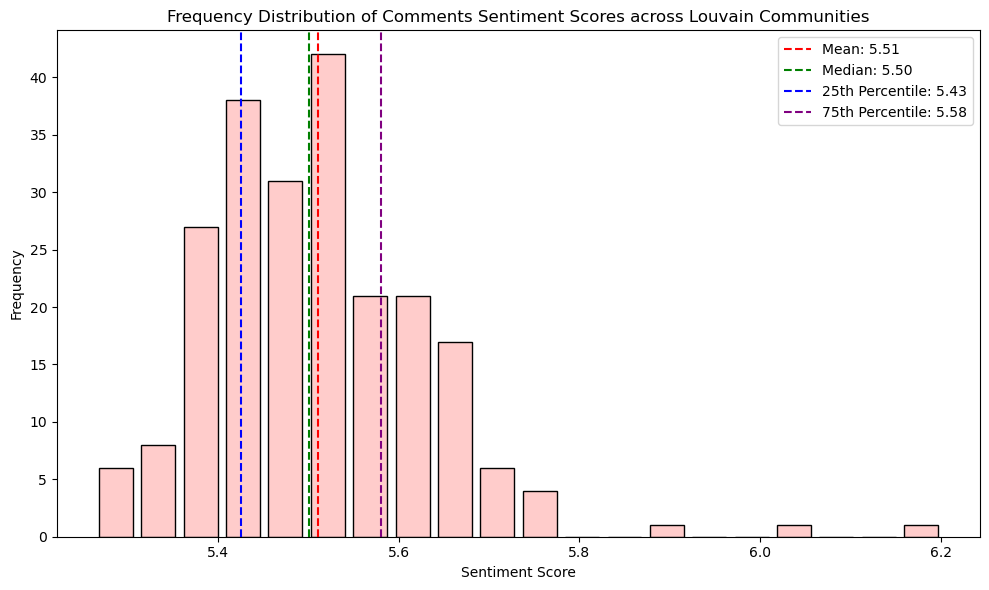

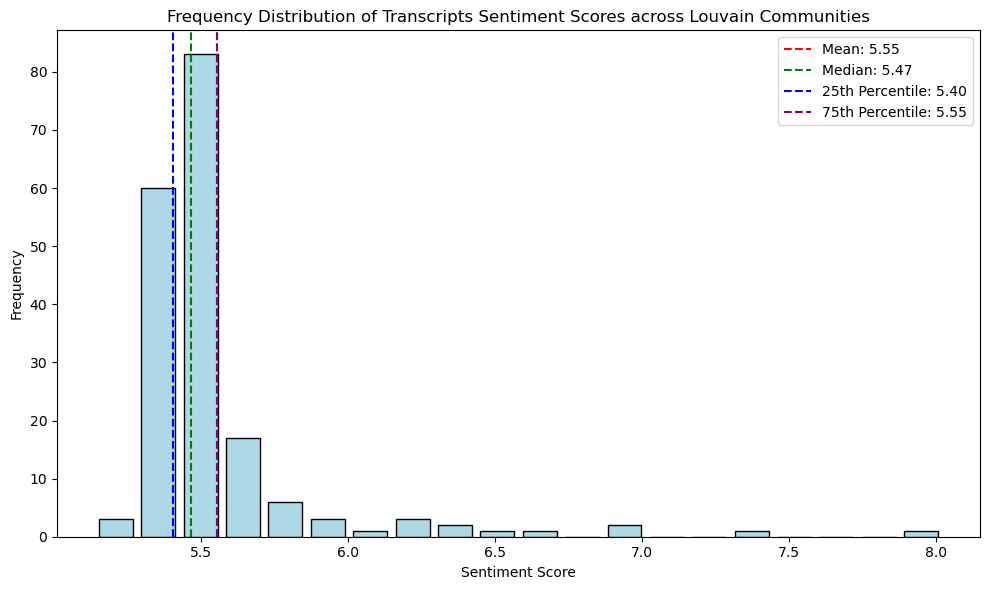

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistical measures for community_sentiments_comments
comments_sentiments = list(community_sentiments_comments.values())
transcripts_sentiments = list(community_sentiments_transcripts.values())

# Statistical measures for comments
mean_sentiment_comments = np.mean(comments_sentiments)
median_sentiment_comments = np.median(comments_sentiments)
variance_sentiment_comments = np.var(comments_sentiments)
percentile_25_comments = np.percentile(comments_sentiments, 25)
percentile_75_comments = np.percentile(comments_sentiments, 75)
min_sentiment_comments = min(comments_sentiments)
max_sentiment_comments = max(comments_sentiments)

# Statistical measures for transcripts
mean_sentiment_transcripts = np.mean(transcripts_sentiments)
median_sentiment_transcripts = np.median(transcripts_sentiments)
variance_sentiment_transcripts = np.var(transcripts_sentiments)
percentile_25_transcripts = np.percentile(transcripts_sentiments, 25)
percentile_75_transcripts = np.percentile(transcripts_sentiments, 75)
min_sentiment_transcripts = min(transcripts_sentiments)
max_sentiment_transcripts = max(transcripts_sentiments)

# Print statistical measures with min and max
print("Comments Sentiment Statistics across Louvain Communities:")
print(f"Mean: {mean_sentiment_comments:.2f}")
print(f"Median: {median_sentiment_comments:.2f}")
print(f"Variance: {variance_sentiment_comments:.2f}")
print(f"Min: {min_sentiment_comments:.2f}")
print(f"Max: {max_sentiment_comments:.2f}")
print(f"25th Percentile: {percentile_25_comments:.2f}")
print(f"75th Percentile: {percentile_75_comments:.2f}")

print("\nTranscripts Sentiment Statistics across Louvain Communities:")
print(f"Mean: {mean_sentiment_transcripts:.2f}")
print(f"Median: {median_sentiment_transcripts:.2f}")
print(f"Variance: {variance_sentiment_transcripts:.2f}")
print(f"Min: {min_sentiment_transcripts:.2f}")
print(f"Max: {max_sentiment_transcripts:.2f}")
print(f"25th Percentile: {percentile_25_transcripts:.2f}")
print(f"75th Percentile: {percentile_75_transcripts:.2f}")

# Function to plot frequency distribution of sentiments with statistics
def plot_sentiment_distribution_with_stats(sentiments, stats, title, color, xlabel='Sentiment Score', ylabel='Frequency'):
    # Calculate frequency distribution
    num_bins = 20
    bin_edges = np.linspace(min(sentiments), max(sentiments), num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    frequencies, _ = np.histogram(sentiments, bins=bin_edges)
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    bar_width = (bin_edges[1] - bin_edges[0]) * 0.8  # Adjust bar width for spacing
    plt.bar(bin_centers, frequencies, width=bar_width, color=color, edgecolor='black')
    
    # Add precomputed statistics as vertical lines
    plt.axvline(stats["Mean"], color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {stats["Mean"]:.2f}')
    plt.axvline(stats["Median"], color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {stats["Median"]:.2f}')
    plt.axvline(stats["25th Percentile"], color='blue', linestyle='dashed', linewidth=1.5, label=f'25th Percentile: {stats["25th Percentile"]:.2f}')
    plt.axvline(stats["75th Percentile"], color='purple', linestyle='dashed', linewidth=1.5, label=f'75th Percentile: {stats["75th Percentile"]:.2f}')
    
    # Add title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot frequency distribution for comments with stats
plot_sentiment_distribution_with_stats(
    comments_sentiments,
    {
        "Mean": mean_sentiment_comments,
        "Median": median_sentiment_comments,
        "25th Percentile": percentile_25_comments,
        "75th Percentile": percentile_75_comments,
    },
    title='Frequency Distribution of Comments Sentiment Scores across Louvain Communities',
    color='#ffcccb'  # Light pink
)

# Plot frequency distribution for transcripts with stats
plot_sentiment_distribution_with_stats(
    transcripts_sentiments,
    {
        "Mean": mean_sentiment_transcripts,
        "Median": median_sentiment_transcripts,
        "25th Percentile": percentile_25_transcripts,
        "75th Percentile": percentile_75_transcripts,
    },
    title='Frequency Distribution of Transcripts Sentiment Scores across Louvain Communities',
    color='#add8e6'  # Light blue
)

### THIS IS NOT DONE, IGNORE: Determining structural communities (whilst allowing for overlapping communities) by using the Clique Percolation Method (CPM):

In [1]:
# Parameters for k-clique community detection
k = 3  # Minimum size of cliques

# Detect overlapping communities using k-clique
overlapping_communities = list(k_clique_communities(G, k))

# Print the number of detected communities
print(f"Number of {k}-clique communities: {len(overlapping_communities)}")

# Assign communities to nodes (overlapping memberships)
node_memberships = {}
for idx, community in enumerate(overlapping_communities):
    for node in community:
        node_memberships.setdefault(node, []).append(idx)

# Add overlapping communities as a node attribute
nx.set_node_attributes(G, node_memberships, "overlapping_communities")

# Create a non-overlapping partition approximation
non_overlapping_partition = {}
for community in overlapping_communities:
    for node in community:
        if node not in non_overlapping_partition:
            non_overlapping_partition[node] = community

# Convert to a list of sets for modularity calculation
approx_partition = [set(nodes) for nodes in non_overlapping_partition.values()]

# Calculate modularity
modularity_value = modularity(G, approx_partition)

print(f"Number of {k}-clique communities: {len(overlapping_communities)}")
print(f"Modularity of {k}-clique communities (approximation): {modularity_value:.5f}")

NameError: name 'k_clique_communities' is not defined

## OLD CODE THAT WE DONT USE ANYMORE:

Printing the info from one video to check if everything has been stored correctly:

In [7]:
# Choose a specific node (replace 'node_name' with the actual node name you want to inspect)
node_name = "_7djFt3SIt0"

if node_name in G.nodes:
    print(f"Attributes of node '{node_name}':")
    for key, value in G.nodes[node_name].items():
        print(f"  {key}: {value}")
else:
    print(f"Node '{node_name}' not found in the graph.")

Attributes of node '_7djFt3SIt0':
  comments: ✔ Did you subscribe to 𝗫𝗛𝗘𝗡𝗦𝗜𝗟𝗔 𝗠𝗬𝗥𝗧𝗘𝗭𝗔𝗝's Official channel? 👇🏼
►  https://smarturl.it/SubXhensilaMyrtezaj
🎧 Listen on Spotify / Download on iTunes 👇🏼
► https://music.fole.to/XhensilaElinelAekeprovu
Kont Faleman Morys is totoration.
Give heart you are the star 🌟🌟🌟🌟🌟je Star
Every song of yours is Superime Only your songs listen to
She has a beautiful face and body. Her energy is so exotic. 🫶🏼
But her “dance and move” is comedic. Not a good actress for her own production. 🫥 She needs to have personal assistant to make up the movements for her videos.
2000s
Fails
How much one thing I do.
Who thinks this is in vain song of Gensiel total failure 😏😏
Is Gensila or Snow?
shake she shakes Jenny
❤🎉❤❤view beautiful
Has Copy Dafina Zeqiri to scene with identical newspapers
Turp tet vij my femer by you is nen
Delete how much you are in time let nam
World Star Gesila with these outfits good at all 1 star as you are bare I bare my values ​​❤
I love you❤❤❤